## Process Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [5]:
df = pd.read_csv("./data/data_cvd.csv", index_col=0, decimal=',')
df = df.convert_dtypes()

(7466, 60)

In [3]:
# recovering missing cholesterol LDL values
# Colesterolo LDL = colesterolo totale - [colesterolo HDL + (trigliceridemia/5)]
ct, chdl, cldl, ctrig = 0, 0, 0, 0
incorrect = []

for i in df.index:
    total = df.loc[i, "Total cholesterol"]
    hdl = df.loc[i, "HDL"]
    ldl = df.loc[i, "LDL"]
    trig = df.loc[i, "Triglycerides"]

    count = pd.isna(total) + pd.isna(hdl) + pd.isna(ldl) + pd.isna(trig)
    # remove the patients with a wrong cholesterol values
    # some values are ok, they are only 1 off
    if (count == 0):
        tmp = round(total - (hdl + (trig/5)))
        if (abs(ldl - tmp) > 1):
            incorrect.append(i)

    # fill the <NA>
    if (count == 1):
        if (pd.isna(total)):
            ct += 1
        if (pd.isna(hdl)):
            chdl += 1
        # if (pd.isna(ldl) == False):
        if (pd.isna(ldl)):
            tmp = round(total - (hdl + (trig/5)))
            df.loc[i, "LDL"] = tmp
            cldl += 1
            # print(i, " patient", ldl, "\t", tmp)
        if (pd.isna(trig)):
            ctrig += 1

print("Only total cholest. <NA>: \t", ct)
print("Only HDL <NA>: \t\t\t", chdl)
print("Only LDL <NA>: \t\t\t", cldl)
print("Only Triglycerides <NA>: \t", ctrig)

df_clean = df.drop(incorrect)
print("\nIncorrect values: ", len(incorrect))

# 0.16 is not far from 0.13
# no correlation, those are wrong values
# (df.loc[incorrect, "CVD Death"] == 1).sum()/len(incorrect)

Only total cholest. <NA>: 	 2
Only HDL <NA>: 			 1
Only LDL <NA>: 			 453
Only Triglycerides <NA>: 	 17

Incorrect values:  273


## Create target feature, survive X years

In [6]:
years = 7

# create the target feature
survive = (df["Interval (Years)"] < years) & df["CVD Death"]
survive = (survive + 1) % 2

# drop all the follow up features and the scarse features
df_feat = df_clean.iloc[:, :45]
df_feat[f"Survive{years}Y"] = survive
df_feat = df_feat.drop(columns=["Hospital admission", "T3", "T4", "Vessels", "Weight", "Height"])

# drop all the remaining na patients
df_feat = df_feat.dropna()
print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))

(7193, 46)
Total patient: 	 6149
Survived: 	 5459 	 0.8877866319726785
Dead: 		 690 	 0.11221336802732151


In [32]:
# 1. dataset split
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_feat, test_size=0.2, stratify=df_feat.iloc[:,-1])
df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train.iloc[:,-1])
# df_train.to_csv(f"data/{years}y/train.csv")
# df_valid.to_csv(f"data/{years}y/valid.csv")
# df_test.to_csv(f"data/{years}y/test.csv")

/home/dot/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dot/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/dot/.local/lib/python3.8/site-packages/matplotlib/backends/_backend_pdf_ps.py:109: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=ft2font.LOAD_NO_HINTING)
/home/dot/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/dot/.local/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


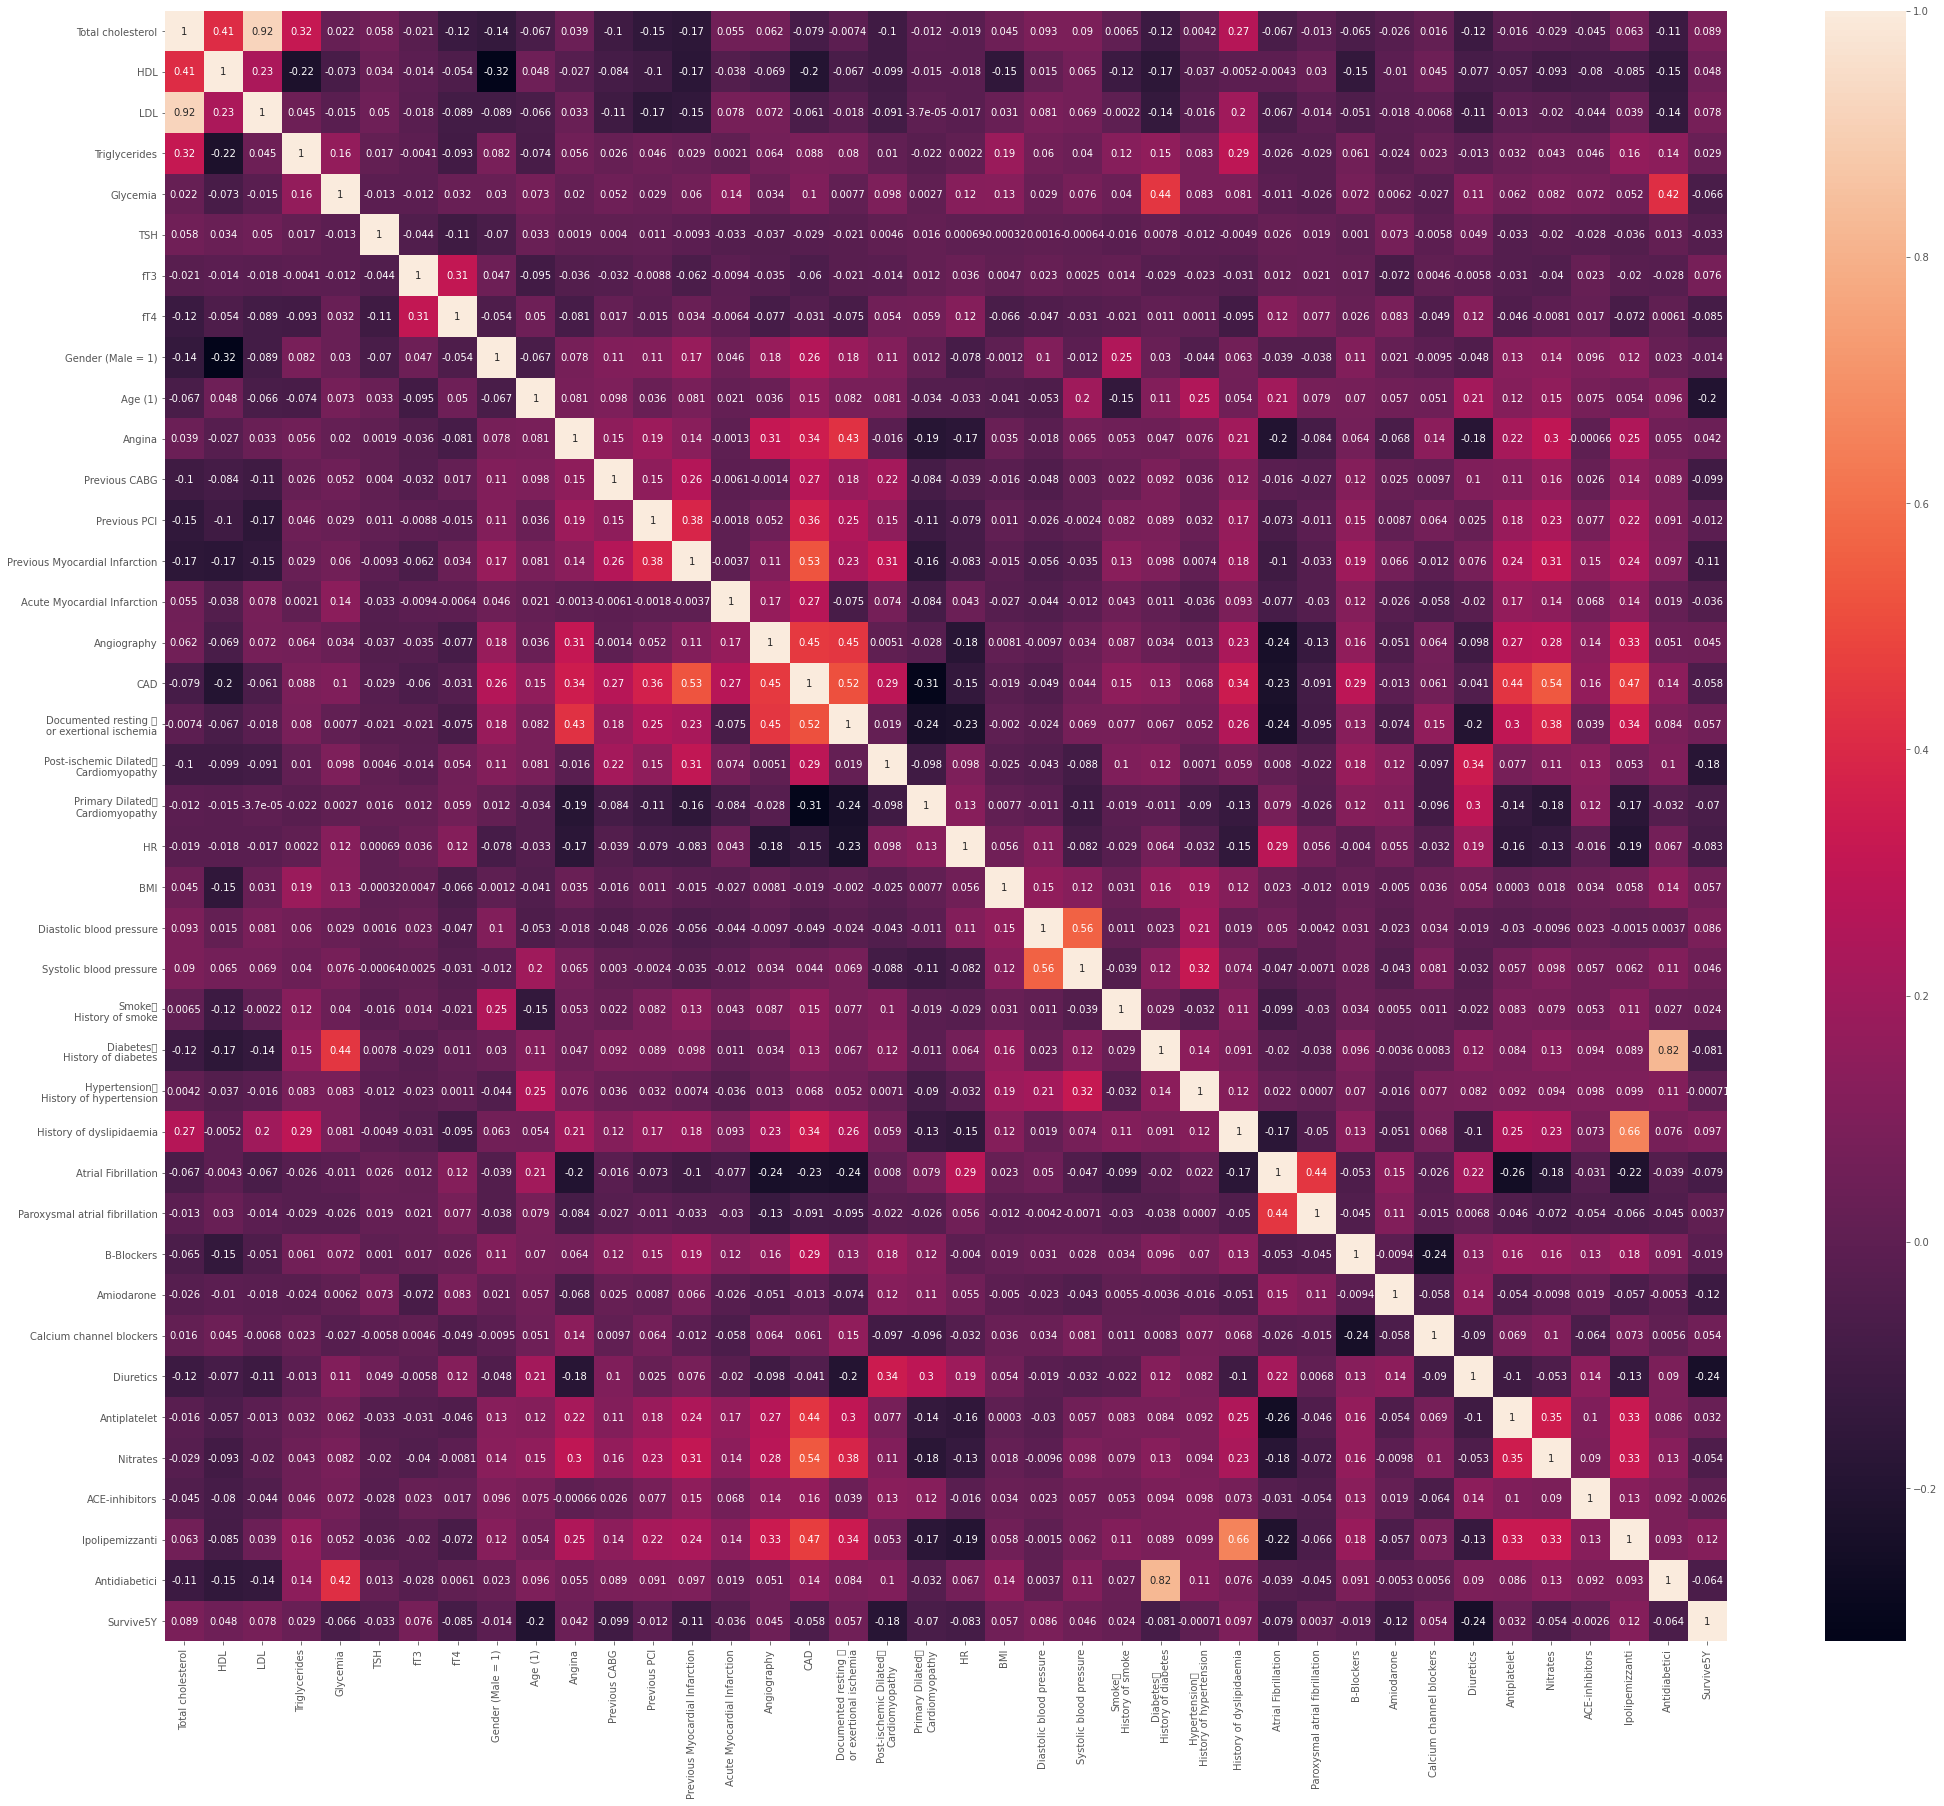

In [16]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(35,30))
sns.heatmap(df_feat.corr(), annot=True)
fig.savefig("feat.pdf")